In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
!pip install contractions
import contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 9.9 MB/s eta 0:00:00


In [3]:
!pip install evaluate
import evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.8 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

RuntimeError: Failed to import transformers.pipelines because of the following error (look up to see its traceback):
cannot import name 'PartialState' from 'accelerate.state' (/opt/conda/lib/python3.10/site-packages/accelerate/state.py)

In [73]:
import re
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    classification_report,
)

from nltk.corpus import stopwords
import seaborn as sns

### Uploading train data

In [5]:
train_tw = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

## Exploratory data analysis

### Looking at the data

In [ ]:
train_tw.head()

In [ ]:
train_tw.keyword.value_counts().index.to_list()

In [ ]:
train_tw.info()

In [ ]:
locations = train_tw.location.value_counts().index.to_list()
print(locations)

In [ ]:
train_tw.shape

In [ ]:
train_tw.target.value_counts()

In [ ]:
# print (train_tw.loc[3107: 3142, 'text'])
for row in range(3107, 3142):
    print (train_tw.loc[row, 'text'])

#### Let us now see the distribution of the tweets lengths in quantiles.

In [ ]:
train_tw['tweet_length'] = [len(tweet.split()) for tweet in train_tw.text]
train_tw.head()

In [ ]:
train_tw.tweet_length.value_counts()

In [ ]:
train_tw.tweet_length.nunique()

In [ ]:
print(train_tw['tweet_length'].quantile([0.01, 0.05, 0.10, 0.5, 0.9, 0.95, 0.99]))

In [ ]:
def plot_tweets_length_distrib(column):

    fig, ax = plt.subplots(1, 3, figsize=(16, 4))
    fig = plt.figure(figsize=(5, 10))

    lengths = [len(tweet.split()) for tweet in train_tw[column]]
    ax[0].hist(lengths, bins=31, linewidth=0.5, edgecolor="white")

    lengths = [len(tweet.split()) for tweet in train_tw[train_tw['target'] == 1][column]]
    ax[1].hist(lengths, bins=31, linewidth=0.5, edgecolor="white")

    lengths = [len(tweet.split()) for tweet in train_tw[train_tw['target'] == 0][column]]
    ax[2].hist(lengths, bins=31, linewidth=0.5, edgecolor="white")

    names = ['Common distribution', 'Distribution of disaster tweets.',
             'Distribution of calm tweets.']
    for i in range(len(names)):
        ax[i].set_title(names[i])
        ax[i].set_xlabel('Length')
        ax[i].set_ylabel('Number of tweets')

In [ ]:
plot_tweets_length_distrib('text')

#### Processing tweets. Let us try to find in the tweets characteristic symbols, like as URL's, html's, special characters, @ etc. In case some of them are found, we remove them.

In [6]:
# We introduce counters for every matching found to see how many of them are found:
matches = {'URL': 0, 'html': 0, 'spec_char': 0, 'at': 0, 'hashtags': 0, 'non_ascii': 0,
           'multiples_!': 0, 'multiples_?': 0, 'stop words': 0,
           'typos': 0, 'acronyms': 0, 'abbr': 0}
        
# Patterns for URL's
https_pattern = re.compile(r"https?://\S+|www\.\S+")
# Patterns for html's
html_pattern = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
# Patterns for special characters
emoji_pattern = re.compile(
                            '['
                            u'\U0001F600-\U0001F64F'  # emoticons
                            u'\U0001F300-\U0001F5FF'  # symbols & pictographs
                            u'\U0001F680-\U0001F6FF'  # transport & map symbols
                            u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
                            u'\U00002702-\U000027B0'
                            u'\U000024C2-\U0001F251'
                            ']+',
                            flags=re.UNICODE
    )
# Patterns for character sequences with At symbol (@)
at_pattern = re.compile(r'@\S*')
# Patterns for hashtag symbols
hashtag_pattern = re.compile(r'#([^\s]+)')
# Patterns for non_ascii characters:
non_ascii_pattern = re.compile(r'[^\x00-\x7f]')
# Patterns for sequences of several '!'
multiples_pattern_1 = re.compile(r'!+')
# Patterns for sequences of several '?'
multiples_pattern_2 = re.compile(r'\?+')

# Pattern for english stopwords
stopwords_list = stopwords.words('english')
stopwords_pattern = re.compile(r'(?<!\w)(' + '|'.join(word \
                        for word in stopwords_list) + r')(?!\w)')

# Taking into account typos, slang and other:
sample_typos_slang = {
                        "w/e": "whatever",
                        "usagov": "usa government",
                        "recentlu": "recently",
                        "ph0tos": "photos",
                        "amirite": "am i right",
                        "exp0sed": "exposed",
                        "<3": "love",
                        "luv": "love",
                        "amageddon": "armageddon",
                        "trfc": "traffic",
                        "16yr": "16 year"
                        }
sample_typos_slang_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) \
                            for key in sample_typos_slang.keys()) + r')(?!\w)')

# Acronyms
sample_acronyms =  { 
                    "mh370": "malaysia airlines flight 370",
                    "okwx": "oklahoma city weather",
                    "arwx": "arkansas weather",    
                    "gawx": "georgia weather",  
                    "scwx": "south carolina weather",  
                    "cawx": "california weather",
                    "tnwx": "tennessee weather",
                    "azwx": "arizona weather",  
                    "alwx": "alabama weather",
                    "usnwsgov": "united states national weather service",
                    "2mw": "tomorrow"
                    }
sample_acronyms_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) \
                            for key in sample_acronyms.keys()) + r')(?!\w)')

# Some common english abbreviations: 
sample_abbr = {     "$" : " dollar ",
                    "€" : " euro ",
                    "4ao" : "for adults only",
                    "a.m" : "before midday",
                    "a3" : "anytime anywhere anyplace",
                    "aamof" : "as a matter of fact",
                    "acct" : "account",
                    "adih" : "another day in hell",
                    "afaic" : "as far as i am concerned",
                    "afaict" : "as far as i can tell",
                    "afaik" : "as far as i know",
                    "afair" : "as far as i remember",
                    "afk" : "away from keyboard",
                    "app" : "application",
                    "approx" : "approximately",
                    "apps" : "applications",
                    "asap" : "as soon as possible",
                    "asl" : "age, sex, location",
                    "atk" : "at the keyboard",
                    "ave." : "avenue",
                    "aymm" : "are you my mother",
                    "ayor" : "at your own risk", 
                    "b&b" : "bed and breakfast",
                    "b+b" : "bed and breakfast",
                    "b.c" : "before christ",
                    "b2b" : "business to business",
                    "b2c" : "business to customer",
                    "b4" : "before",
                    "b4n" : "bye for now",
                    "b@u" : "back at you",
                    "bae" : "before anyone else",
                    "bak" : "back at keyboard",
                    "bbbg" : "bye bye be good",
                    "bbc" : "british broadcasting corporation",
                    "bbias" : "be back in a second",
                    "bbl" : "be back later",
                    "bbs" : "be back soon",
                    "be4" : "before",
                    "bfn" : "bye for now",
                    "blvd" : "boulevard",
                    "bout" : "about",
                    "brb" : "be right back",
                    "bros" : "brothers",
                    "brt" : "be right there",
                    "bsaaw" : "big smile and a wink",
                    "btw" : "by the way",
                    "bwl" : "bursting with laughter",
                    "c/o" : "care of",
                    "cet" : "central european time",
                    "cf" : "compare",
                    "cia" : "central intelligence agency",
                    "csl" : "can not stop laughing",
                    "cu" : "see you",
                    "cul8r" : "see you later",
                    "cv" : "curriculum vitae",
                    "cwot" : "complete waste of time",
                    "cya" : "see you",
                    "cyt" : "see you tomorrow",
                    "dae" : "does anyone else",
                    "dbmib" : "do not bother me i am busy",
                    "diy" : "do it yourself",
                    "dm" : "direct message",
                    "dwh" : "during work hours",
                    "e123" : "easy as one two three",
                    "eet" : "eastern european time",
                    "eg" : "example",
                    "embm" : "early morning business meeting",
                    "encl" : "enclosed",
                    "encl." : "enclosed",
                    "etc" : "and so on",
                    "faq" : "frequently asked questions",
                    "fawc" : "for anyone who cares",
                    "fb" : "facebook",
                    "fc" : "fingers crossed",
                    "fig" : "figure",
                    "fimh" : "forever in my heart", 
                    "ft." : "feet",
                    "ft" : "featuring",
                    "ftl" : "for the loss",
                    "ftw" : "for the win",
                    "fwiw" : "for what it is worth",
                    "fyi" : "for your information",
                    "g9" : "genius",
                    "gahoy" : "get a hold of yourself",
                    "gal" : "get a life",
                    "gcse" : "general certificate of secondary education",
                    "gfn" : "gone for now",
                    "gg" : "good game",
                    "gl" : "good luck",
                    "glhf" : "good luck have fun",
                    "gmt" : "greenwich mean time",
                    "gmta" : "great minds think alike",
                    "gn" : "good night",
                    "g.o.a.t" : "greatest of all time",
                    "goat" : "greatest of all time",
                    "goi" : "get over it",
                    "gps" : "global positioning system",
                    "gr8" : "great",
                    "gratz" : "congratulations",
                    "gyal" : "girl",
                    "h&c" : "hot and cold",
                    "hp" : "horsepower",
                    "hr" : "hour",
                    "hrh" : "his royal highness",
                    "ht" : "height",
                    "ibrb" : "i will be right back",
                    "ic" : "i see",
                    "icq" : "i seek you",
                    "icymi" : "in case you missed it",
                    "idc" : "i do not care",
                    "idgadf" : "i do not give a damn fuck",
                    "idgaf" : "i do not give a fuck",
                    "idk" : "i do not know",
                    "ie" : "that is",
                    "i.e" : "that is",
                    "ifyp" : "i feel your pain",
                    "IG" : "instagram",
                    "iirc" : "if i remember correctly",
                    "ilu" : "i love you",
                    "ily" : "i love you",
                    "imho" : "in my humble opinion",
                    "imo" : "in my opinion",
                    "imu" : "i miss you",
                    "iow" : "in other words",
                    "irl" : "in real life",
                    "j4f" : "just for fun",
                    "jic" : "just in case",
                    "jk" : "just kidding",
                    "jsyk" : "just so you know",
                    "l8r" : "later",
                    "lb" : "pound",
                    "lbs" : "pounds",
                    "ldr" : "long distance relationship",
                    "lmao" : "laugh my ass off",
                    "lmfao" : "laugh my fucking ass off",
                    "lol" : "laughing out loud",
                    "ltd" : "limited",
                    "ltns" : "long time no see",
                    "m8" : "mate",
                    "mf" : "motherfucker",
                    "mfs" : "motherfuckers",
                    "mfw" : "my face when",
                    "mofo" : "motherfucker",
                    "mph" : "miles per hour",
                    "mr" : "mister",
                    "mrw" : "my reaction when",
                    "ms" : "miss",
                    "mte" : "my thoughts exactly",
                    "nagi" : "not a good idea",
                    "nbc" : "national broadcasting company",
                    "nbd" : "not big deal",
                    "nfs" : "not for sale",
                    "ngl" : "not going to lie",
                    "nhs" : "national health service",
                    "nrn" : "no reply necessary",
                    "nsfl" : "not safe for life",
                    "nsfw" : "not safe for work",
                    "nth" : "nice to have",
                    "nvr" : "never",
                    "nyc" : "new york city",
                    "oc" : "original content",
                    "og" : "original",
                    "ohp" : "overhead projector",
                    "oic" : "oh i see",
                    "omdb" : "over my dead body",
                    "omg" : "oh my god",
                    "omw" : "on my way",
                    "p.a" : "per annum",
                    "p.m" : "after midday",
                    "pm" : "prime minister",
                    "poc" : "people of color",
                    "pov" : "point of view",
                    "pp" : "pages",
                    "ppl" : "people",
                    "prw" : "parents are watching",
                    "ps" : "postscript",
                    "pt" : "point",
                    "ptb" : "please text back",
                    "pto" : "please turn over",
                    "qpsa" : "what happens", #"que pasa",
                    "ratchet" : "rude",
                    "rbtl" : "read between the lines",
                    "rlrt" : "real life retweet", 
                    "rofl" : "rolling on the floor laughing",
                    "roflol" : "rolling on the floor laughing out loud",
                    "rotflmao" : "rolling on the floor laughing my ass off",
                    "rt" : "retweet",
                    "ruok" : "are you ok",
                    "sfw" : "safe for work",
                    "sk8" : "skate",
                    "smh" : "shake my head",
                    "sq" : "square",
                    "srsly" : "seriously", 
                    "ssdd" : "same stuff different day",
                    "tbh" : "to be honest",
                    "tbs" : "tablespooful",
                    "tbsp" : "tablespooful",
                    "tfw" : "that feeling when",
                    "thks" : "thank you",
                    "tho" : "though",
                    "thx" : "thank you",
                    "tia" : "thanks in advance",
                    "til" : "today i learned",
                    "tl;dr" : "too long i did not read",
                    "tldr" : "too long i did not read",
                    "tmb" : "tweet me back",
                    "tntl" : "trying not to laugh",
                    "ttyl" : "talk to you later",
                    "u.s." : 'usa',
                    "u" : "you",
                    "u2" : "you too",
                    "u4e" : "yours for ever",
                    "utc" : "coordinated universal time",
                    "w/" : "with",
                    "w/o" : "without",
                    "w8" : "wait",
                    "wassup" : "what is up",
                    "wb" : "welcome back",
                    "wtf" : "what the fuck",
                    "wtg" : "way to go",
                    "wtpa" : "where the party at",
                    "wuf" : "where are you from",
                    "wuzup" : "what is up",
                    "wywh" : "wish you were here",
                    "yd" : "yard",
                    "ygtr" : "you got that right",
                    "ynk" : "you never know",
                    "zzz" : "sleeping bored and tired"
                    }
sample_abbr_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) \
                            for key in sample_abbr.keys()) + r')(?!\w)')

def find_all_URL(text):
    match_obj = re.findall(https_pattern, text)
    matches['URL'] += len(match_obj)

def remove_URL(text):
    # Remove URL's from the string text:
    text = re.sub(https_pattern, "", text)
    return text

def find_all_html(text):
    match_obj = re.findall(html_pattern, text)
    matches['html'] += len(match_obj)

def remove_html(text):
    # Remove html from the string text:
    text = re.sub(html_pattern, "", text)
    return text

def find_all_spec_char(text):
    match_obj = re.findall(emoji_pattern, text)
    matches['spec_char'] += len(match_obj)

def remove_spec_char(text):
    # Remove special characters (like emojis and different graphic characters):
    text = emoji_pattern.sub(r'', text)
    return text

def find_all_at(text):
    match_obj = at_pattern.findall(text)
    matches['at'] += len(match_obj)

def remove_at(text):
    text = at_pattern.sub(r'', text)
    return text

def find_all_hashtags(text):
    match_obj = hashtag_pattern.findall(text)
    matches['hashtags'] += len(match_obj)

def remove_hashtags(text):
    # Remove hashtags from the string text:
    text = hashtag_pattern.sub(r'\1', text)
    return text

def find_all_non_ascii(text):
    match_obj = non_ascii_pattern.findall(text)
    matches['non_ascii'] += len(match_obj)

def remove_non_ascii(text):
    # Remove non-ASCII characters from the string text
    text = non_ascii_pattern.sub(r'', text)
    return text

def find_all_multiples(text):
    match_obj_1 = multiples_pattern_1.findall(text)
    matches['multiples_!'] += len(match_obj_1)
    
    match_obj_2 = multiples_pattern_2.findall(text)
    matches['multiples_?'] += len(match_obj_2)

def remove_multiples(text):
    text = multiples_pattern_1.sub(r'!', text)
    text = multiples_pattern_2.sub(r'?', text)
    return text

def find_all_stopwords(text):
    match_obj = stopwords_pattern.findall(text)
    matches['stop words'] += len(match_obj)

def remove_stopwords(text):
    text = stopwords_pattern.sub('', text)
    return text

def remove_punct(text):
    # Remove all punctuation characters except dot '.':
    return re.sub(r'[]!"$%&\'()*+,/:;=#@?[\\^_`{|}~-]+', "", text)

def find_all_the_rest(text):
    modif_obj = sample_typos_slang_pattern.findall(text)
    matches['typos'] += len(modif_obj)
    
    modif_obj = sample_acronyms_pattern.findall(text)
    matches['acronyms'] += len(modif_obj)
    
    modif_obj = sample_abbr_pattern.findall(text)
    matches['abbr'] += len(modif_obj)
    
def remove_the_rest(text): 
    text = sample_typos_slang_pattern.sub(lambda x: sample_typos_slang[x.group()], text)
    text = sample_acronyms_pattern.sub(lambda x: sample_acronyms[x.group()], text)
    text = sample_abbr_pattern.sub(lambda x: sample_abbr[x.group()], text)
    return text
  
def determine_quantities(text):
    find_all_URL(text)
    find_all_html(text)
    find_all_spec_char(text)
    find_all_at(text)
    find_all_hashtags(text)
    find_all_non_ascii(text)
    find_all_multiples(text)
    find_all_stopwords(text)
    find_all_the_rest(text)
        
def process_text(text):
    text = remove_URL(text)
    text = remove_html(text)
    text = remove_spec_char(text)
    text = remove_at(text)  # At symbols (@) with following ater it alphanumerical characters
    text = remove_hashtags(text)
    text = remove_non_ascii(text)
    text = remove_multiples(text) # Remove repeated characters '!' and '?'
    text = remove_stopwords(text)
#     text = remove_punct(text)
    text = text.lower()
    text = remove_the_rest(text)
    text = contractions.fix(text) # Remove english contractions with the 'contractions' module
    text = text.strip()
    return text

In [ ]:
# for key in matches.keys():
#     matches[key] = 0

# modified_text = process_text("BREAKING: Fairfax County firefighter placed on admin leave amid probe into Facebook post about putting police in 'body bags' dept. says.")
# print(modified_text)
# for key in matches.keys():
#     print(f'В тестовом выражении найдено {key}\'с: {matches[key]}.')

In [27]:
text = 'BREAKING: Fairfax County firefighter placed on admin leave amid probe into Facebook post about putting police in "body bags" dept. says.'
pat = remove_stopwords(text)
print(pat)

BREAKING: Fairfax County firefighter placed  admin leave amid probe  Facebook post  putting police  "body bags" dept. says.


#### We calculate now the quantities of all kinds of characteristic symbols in all the given tweets.

In [7]:
for key in matches.keys():
    matches[key] = 0

train_tw.text.apply(determine_quantities)

print('Found in the tweets:')
for key in matches.keys():
    print(f'{key}: {matches[key]}')

Found in the tweets:
URL: 4723
html: 457
spec_char: 0
at: 2751
hashtags: 3375
non_ascii: 2274
multiples_!: 905
multiples_?: 1255
stop words: 36357
typos: 35
acronyms: 19
abbr: 326


#### Let us remove all or some of them.

In [8]:
train_tw['processed_text'] = train_tw.text.apply(process_text)

In [ ]:
for row in range(1017, 1042):
    print('Original tweet:')
    print (train_tw.loc[row, 'text'])
    print('-'*50)
    print('Cleaned tweet:')
    print(train_tw.loc[row, 'processed_text'])
    print('*'*50)

#### Transforming the type of all the cells in the columns 'keyword' and 'location' to str.

In [9]:
train_tw.keyword = train_tw['keyword'].astype('str')
train_tw.location = train_tw['location'].astype('str')

#### Let's remove rows with empty cells. And in one case, we will try to remove from the data observations without a specified keyword. In another cas, we will try to leave them.

In [10]:
train_tw = train_tw[train_tw['keyword'] != 'nan']
train_tw.dropna(subset='target')
train_tw.dropna(subset='text').reset_index(drop=True, inplace=True)

In [11]:
train_tw.shape

(7552, 6)

#### Let's see now tweets' lengths after their processing.

In [ ]:
train_tw['new_tweet_length'] = [len(tweet.split()) for tweet in train_tw.processed_text]
print(train_tw['new_tweet_length'].quantile([0.01, 0.05, 0.10, 0.5, 0.9, 0.95, 0.99]))

In [ ]:
plot_tweets_length_distrib('processed_text')

In [12]:
train_tw.isna().any()

id                False
keyword           False
location          False
text              False
target            False
processed_text    False
dtype: bool

In [37]:
train_tw.reset_index(drop=True, inplace=True)

In [38]:
train_tw.head()

,id,keyword,location,text,target,processed_text,FastText vectors of words
0,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,wholesale markets ablaze,"{'wholesale': [0.02237519, 0.054389343, 0.0076..."
1,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,we always try bring heavy. metal retweet,"{'we': [-0.22641462, -0.028297843, 0.03269786,..."
2,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,africanbaze: breaking news:nigeria flag set ab...,"{'africanbaze:': [0.018227369, -0.017949063, -..."
3,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,crying ! set ablaze,"{'crying': [0.056361657, 0.042255383, 0.102982..."
4,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,on plus side look at the sky last night it was...,"{'on': [-0.056821056, 0.5490306, 0.13121544, 0..."


#### We add FastText vectors for words in the tweets.

In [ ]:
import fasttext.util

fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print(ft.get_word_vector('he'))

In [14]:
VECTOR_SIZE = ft.get_word_vector('hello')

In [15]:
def get_vectors(text):
    vectors = {}
    words_list = text.split(' ')
    for word in words_list:
        vectors[word] = ft.get_word_vector(word)
    return vectors

Let's add to the data a column with FastText vectrors for every word.

In [16]:
train_tw['FastText vectors of words'] = train_tw.processed_text.apply(get_vectors)

In [29]:
train_tw.loc[7552, 'FastText vectors of words']

{'israel': array([-7.16926754e-02, -5.28641455e-02, -3.61416265e-02, -8.86730663e-03,
        -5.74588776e-02, -4.08293121e-02,  5.14563024e-02,  3.50377671e-02,
        -3.03900670e-02,  9.19037983e-02, -8.82374719e-02,  1.29934266e-01,
         2.37451326e-02, -1.64848670e-01,  8.61881450e-02, -3.33893262e-02,
        -2.27197148e-02,  1.31920129e-02, -1.59477904e-01,  5.44855259e-02,
        -6.31409660e-02, -3.99954021e-02,  1.07169501e-01, -3.05016972e-02,
         2.95634207e-04,  7.45853060e-04,  3.91585492e-02,  2.85110809e-02,
        -3.92698944e-02,  2.18608722e-01, -6.00125454e-02,  4.37912717e-02,
        -4.50623930e-02,  1.75069831e-02,  8.28165635e-02,  1.40773086e-02,
        -3.11183929e-03,  7.85256997e-02,  3.02385427e-02,  3.75785008e-02,
         9.33943503e-03, -3.00073158e-02, -2.01459713e-02, -7.03699747e-03,
        -5.24574183e-02, -2.61667068e-03, -8.36788714e-02,  2.57612951e-02,
        -1.30007686e-02,  6.67317659e-02, -1.97167154e-02, -5.45607917e-02,
  

Let's save this table and download it later for models.

In [ ]:
train_tw.to_pickle('Cleaned_data_with_fasttext_vectors.pkl',
                   compression={'method': 'gzip'})

In [ ]:
train_tw.to_csv('Cleaned_data_with_fasttext_vectors.csv')

### Evaluation of classifiers' results.

In [62]:
def plot_conf_matrix(y_test, y_preds, save=False):
    
    cm = confusion_matrix(y_test, y_preds)
    fig, ax = plt.subplots()
    tick_marks = np.asarray([0, 1])
    plt.xticks(tick_marks)
    plt.yticks(tick_marks)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    if save==True:
        save_plot(fig)
                
    plt.show()

    
def plot_roc_auc(y_test, y_preds_proba, save=False):

    model_auc = roc_auc_score(y_test, y_preds_proba, multi_class='ovr',
                              average='weighted')
    print(f'ROC AUC={model_auc:.4f}')
    # Let's compute ROC AUC
    fpr = {} # False Positive Rate
    tpr = {} # True Positive Rate
    thresh ={}
    n_class = y_preds_proba.shape[1] # 2 classes: disaster tweets and calm ones

    colors = ['tab:blue', 'tab:orange']
    plt.figure(figsize=(8, 6))
    for i in range(n_class):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_preds_proba[:,i], pos_label=i)
        plt.plot(fpr[i], tpr[i], linestyle='--', color=colors[i],
                 label=f'{i} vs Rest (area = {auc(fpr[i], tpr[i]):0.2f})')
        
    plt.plot([0, 1], [0, 1], color='tab:gray', linestyle='--')
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    
    if save==True:
        save_plot(fig)
        
    plt.show()

def save_plot(fig):
    now_time = strftime("%Y-%m-%d %H-%M-%S", gmtime())
    current_dir = os.getcwd()
    # Let's create a new folder to save the graph
    new_path = os.path.join(current_dir, 'results')
    os.makedirs(new_path, exist_ok=True)
    file_path = os.path.join(new_path, 'results', f'conf_matrix {now_time}.png')

    fig.savefig(file_path)

In [68]:
def evaluate_results(y_test, y_preds, y_preds_proba, save=False):
    
    plot_conf_matrix(y_test, y_preds, save=save)
#     plot_roc_auc(y_test, y_preds_proba, save=save)
        
    print(classification_report(y_test, y_preds))
    print(f'Accuracy: {accuracy_score(y_test, y_preds)}')
    print(f'f1_score: {f1_score(y_test, y_preds, average="weighted")}')

### Training classifiers and classifying test tweets.

#### Splitting data to train and validation sets:

In [ ]:
# import gensim.downloader as api

# glove_vectors = api.load('glove-twitter-200')
# print(glove_vectors.get_vector('tweeting'))

In [45]:
SENTENCE_VECTOR_TYPE = 'mean'  # 'weighted'
VECTOR_SIZE = 300

def mean_sentence_vector():
    summarized_vector = np.zeros(VECTOR_SIZE)
    sentences_vectors = []
    
    limit = len(train_tw)
    for row in range(limit):
        words_vectors_dict = train_tw.loc[row, 'FastText vectors of words']
        for vector in words_vectors_dict.values():
            summarized_vector += vector
        number = len(words_vectors_dict.values())
        sentence_vector = summarized_vector / number

        sentences_vectors.append(sentence_vector)
        
    train_tw['sentence vector'] = sentences_vectors

def weighted_sentence_vector():
    
    corpus = train_tw.processed_text
    vectorizer = TfidfVectorizer(token_pattern=r'(?!<\w)([a-zA-Z]+)(?!\w)')
    tfidf_vectors = vectorizer.fit_transform(corpus)
    # token_pattern=r'(?!<\w)([a-zA-Z]+)(?!\w)'

    # print(len(vectorizer.get_feature_names_out()))
    print(f'The array of Tf-idf words sentences has the shape: {tfidf_vectors.shape}.')
    
    vectors_df = pd.DataFrame(tfidf_vectors.toarray(),
                          columns = vectorizer.get_feature_names_out()).T
    print(vectors_df)
    
    limit = len(train_tw)
    for row in range(limit):
        words_list = train_tw['FastText vectors of words']
        sentence_vector = np.zeros(VECTOR_SIZE)

        for word in words_list.keys():
            sentence_vector += words_list['word'] * vectors_df.loc[word, row]

        train_tw['sentence_vector'] = sentence_vector

def vectorize_sentences():
    if SENTENCE_VECTOR_TYPE == 'mean':
        mean_sentence_vector()
#         return train_tw['FastText vectors of words'].apply(mean_sentence_vector)
    else:
        return weighted_sentence_vector()

In [ ]:
vectorize_sentences()

In [56]:
print(type(train_tw.loc[19, 'sentence vector'].tolist()))

<class 'list'>


In [57]:
X = train_tw['sentence vector'].tolist()
Y = train_tw.target
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42,
                                                    shuffle=True)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AttributeError: module 'numpy' has no attribute 'as_array'

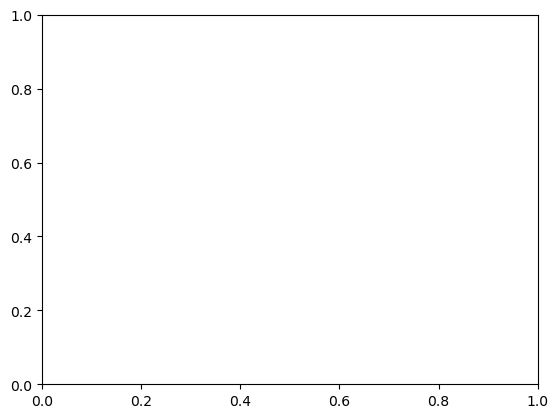

In [61]:
lr = LogisticRegression(random_state=42)
lr.fit(x_train, y_train)
y_preds = lr.predict(x_val)
y_preds_proba = lr.predict_proba(x_val)
evaluate_results(y_val, y_preds, y_preds_proba)

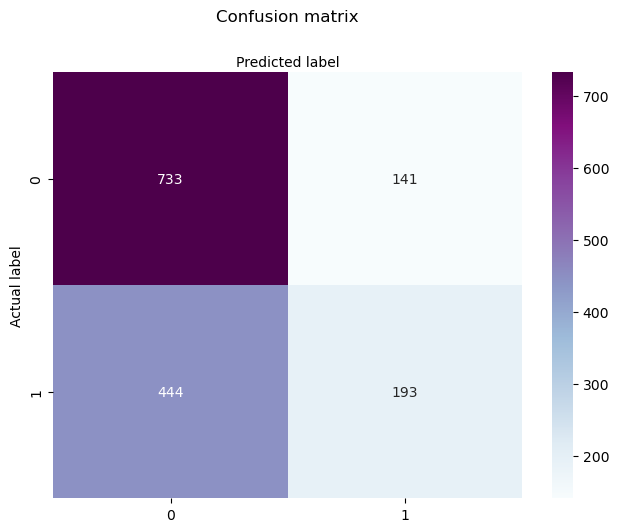

              precision    recall  f1-score   support

           0       0.62      0.84      0.71       874
           1       0.58      0.30      0.40       637

    accuracy                           0.61      1511
   macro avg       0.60      0.57      0.56      1511
weighted avg       0.60      0.61      0.58      1511

Accuracy: 0.6128391793514228
f1_score: 0.5810307005683619


In [69]:
evaluate_results(y_val, y_preds, y_preds_proba)

In [78]:
lr_params_grid = [{
        'penalty': ('l1', 'l2', 'elasticnet'),
        'tol': (1e-3, 1e-4),
        'C': (1.0, 10.0, 50.0, 100.0),
        'solver': ('saga', 'lbfgs'),
        'max_iter': (100, 250, 50)
        },
        {'penalty': 'l2',
         'tol': (1e-3, 1e-4),
         'C': (1.0, 10.0, 50.0, 100.0),
         'solver': ('sag', 'lbfgs', 'newton-cg', 'newton-cholesky'),
         'max_iter': (100, 250, 50)
        }
]
lr = LogisticRegression(random_state=42)
scores = ["precision", "recall"]

clf = GridSearchCV(estimator=lr, param_grid=lr_params_grid, scoring=scores)

In [ ]:
clf.fit(x_train, y_train)